# Cloud Adoption by the Financial Institutions in Angola (DRAFT v0.3)

## Table of Contents

* [Introduction](#Introduction)


# Introduction:
<div style='text-align: justify;'>
<p>
The banking sector is undergoing a transformative shift driven by technological advancements and changing customer expectations. As digitalization becomes imperative, banks are increasingly turning to cloud computing to enhance their agility, drive innovation, and optimize operational efficiency. The adoption of cloud technologies in the banking sector offers opportunities for improved customer experiences, cost savings, and competitive advantages.
</p>
<p>
This research project aims to explore the current state of cloud adoption in the banking sector and examine the opportunities and challenges faced by banks in leveraging cloud technologies. By evaluating the key drivers, barriers, and industry-specific considerations, this study seeks to provide valuable insights and recommendations to support successful cloud adoption strategies in the banking sector.
</p>
</div>

# References:

* [Software as a Service - Worldwide](https://www.statista.com/outlook/tmo/public-cloud/software-as-a-service/worldwide) by Statista

[BeautifulSoup](https://pypi.org/project/beautifulsoup4/) 

**Version:** 0.5
<p>**Description:** Adding the Banks' MX Records to the dataset</p>

This code uses the dns.resolver module from dnspython to retrieve the MX records for each naked domain. The MX records are stored in the "mx_records" column of the CSV file.

This updated code handles common exceptions related to DNS resolution, such as NXDOMAIN, NoNameservers, and NoAnswer. Additionally, it captures any other DNSException and includes the error message in the mx_records field.

In [1]:
!pip3 install dnspython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 5.8 MB/s eta 0:00:00


In [2]:
!pip install python-whois

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for python-whois: filename=python_whois-0.8.0-py3-none-any.whl size=103263 sha256=da8f840938f93a58b8339ba7fbaa66f121509f858f06ee3e7bc9ee47f1721119
  Stored in directory: /root/.cache/pip/wheels/10/f1/87/145023b9a206e2e948be6480c61ef3fd3dbb81ef11b6977782
Successfully built python-whois


In [3]:
import csv
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import dns.resolver
import requests
import whois

# Send a GET request to the webpage
url = "https://www.abanc.ao/sistema-financeiro/instituicoes-bancarias-autorizadas/"
response = requests.get(url)

# Create a BeautifulSoup object to parse the HTML content
soup = BeautifulSoup(response.content, "html.parser")

# Find all bank information div elements
bank_divs = soup.find_all("div", class_="cmsAccordion")

# Initialize an empty list to store the bank details
bank_details = []

# Iterate over each bank div
for bank_div in bank_divs:
    # Extract bank name
    bank_name = bank_div.find("p", class_="heading").text.strip()

    # Extract bank info divs
    bank_info_divs = bank_div.find_all("div", class_="content")

    # Extract bank website
    bank_website = None
    for bank_info_div in bank_info_divs:
        bank_website_element = bank_info_div.find("a")
        if bank_website_element:
            bank_website = bank_website_element["href"]
            break

    # If bank website is not found, check the second occurrence of class "content"
    if not bank_website and len(bank_info_divs) > 1:
        bank_info_div = bank_info_divs[1]
        bank_website_element = bank_info_div.find("a")
        if bank_website_element:
            bank_website = bank_website_element["href"]

    # Extract the naked domain from the bank website URL
    naked_domain = None
    if bank_website:
        parsed_url = urlparse(bank_website)
        netloc = parsed_url.netloc
        if netloc.startswith("www."):
            naked_domain = netloc[4:]  # Remove "www" part from the domain
        else:
            naked_domain = netloc

    # Retrieve MX records for the naked domain
    mx_records = None
    if naked_domain:
        try:
            answers = dns.resolver.resolve(naked_domain, "MX")
            mx_records = [str(r.exchange)[:-1] for r in answers]
        except (dns.resolver.NXDOMAIN, dns.resolver.NoNameservers, dns.resolver.NoAnswer):
            mx_records = "No MX records found"
        except dns.exception.DNSException as e:
            mx_records = f"Error: {str(e)}"

    # Perform DNS lookup on each MX record and perform whois lookup on the IP address
    org_names = []
    if mx_records and mx_records != "No MX records found":
        for mx_record in mx_records:
            try:
                answers = dns.resolver.resolve(mx_record, "A")
                ip_address = answers[0].address

                whois_info = whois.whois(ip_address)
                org_name = whois_info.get("org")
                if org_name:
                    org_names.append(org_name)

            except (dns.resolver.NXDOMAIN, dns.resolver.NoNameservers, dns.resolver.NoAnswer, whois.parser.PywhoisError):
                continue
            except dns.exception.DNSException as e:
                print(f"Error performing DNS lookup for {mx_record}: {str(e)}")
            except Exception as e:
                print(f"Error performing whois lookup for {ip_address}: {str(e)}")

    # Create a dictionary to store the bank details
    bank = {
        "name": bank_name,
        "website": bank_website,
        "naked_domain": naked_domain,
        "mx_records": mx_records,
        "org_names": org_names
    }

    # Append the bank details to the list
    bank_details.append(bank)

# Specify the output CSV file path
csv_file = "bank_details-5.0.1.csv"

# Write the bank details to the CSV file
with open(csv_file, "w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=["name", "website", "naked_domain", "mx_records", "org_names"])
    writer.writeheader()
    writer.writerows(bank_details)

print("Bank details written to", csv_file)

Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
Bank details written to bank_details-5.0.1.csv


***Version:*** 5.0.1

***Description:*** Plotting the info using the local dataset (Generated by the previous version of the code)

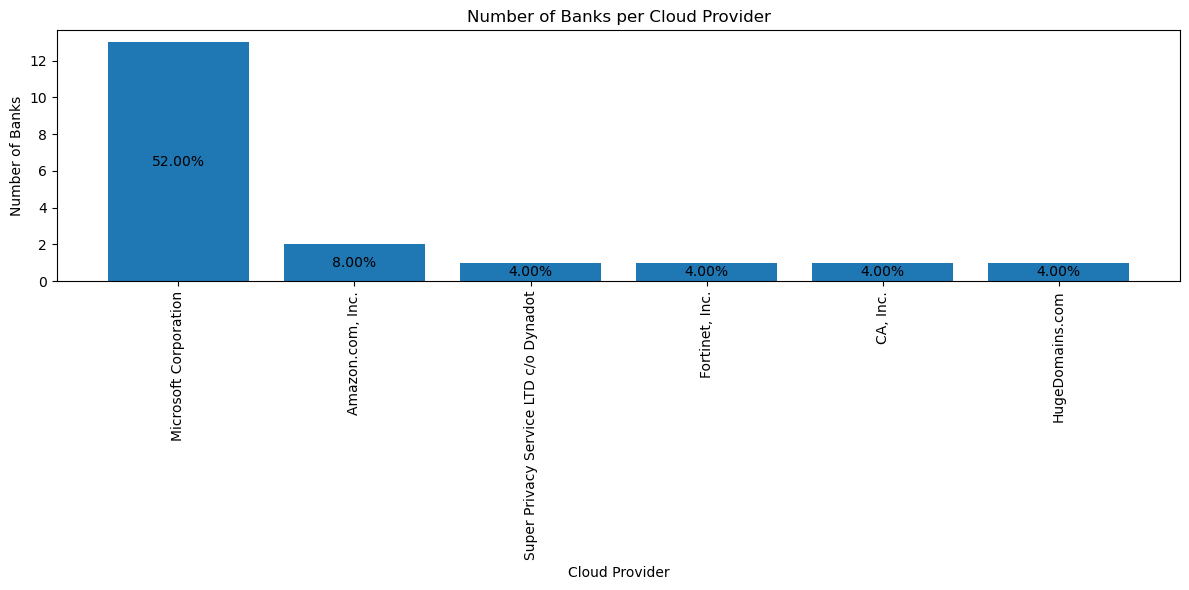

In [4]:
import csv
import ast
import matplotlib.pyplot as plt

# Specify the input CSV file path
csv_file = "/kaggle/input/bankdetails501/bank_details-5.0.1.csv"

# Read the bank details from the CSV file
bank_details = []
with open(csv_file, "r", encoding="utf-8") as file:
    reader = csv.DictReader(file)
    for row in reader:
        row["org_names"] = ast.literal_eval(row["org_names"])
        bank_details.append(row)

# Count the unique occurrences of each org_name
org_name_counts = {}
for bank in bank_details:
    org_names = bank["org_names"]
    unique_org_names = set(org_names)  # Remove duplicates within a row
    for org_name in unique_org_names:
        org_name = org_name.strip("'")  # Remove the single quotes from the Org Name
        if org_name in org_name_counts:
            org_name_counts[org_name] += 1
        else:
            org_name_counts[org_name] = 1

# Sort the org_name_counts by count in descending order
sorted_org_name_counts = sorted(org_name_counts.items(), key=lambda x: x[1], reverse=True)

# Prepare data for plotting
org_names = [item[0] for item in sorted_org_name_counts]
counts = [item[1] for item in sorted_org_name_counts]

# Calculate total number of banks
total_banks = len(bank_details)

# Calculate percentage for each org_name
percentages = [(count / total_banks) * 100 for _, count in sorted_org_name_counts]

# Plot the bar chart with percentage annotations
plt.figure(figsize=(12, 6))
bars = plt.bar(org_names, counts)
plt.xlabel("Cloud Provider")
plt.ylabel("Number of Banks")
plt.title("Number of Banks per Cloud Provider")
plt.xticks(rotation=90)
plt.tight_layout()

# Add percentage annotations inside each bar
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f"{percentage:.2f}%", ha='center', va='center')

plt.show()

The code below has been updated in order to make the plot to display the number of banks using each cloud provider along with the total number of banks in the dataset inside each bar. It will also show the overall cloud utilization percentage outside the plot.

Loaded data from CSV file.
Mapped cloud providers for each bank.
Counted the number of banks using each cloud provider.


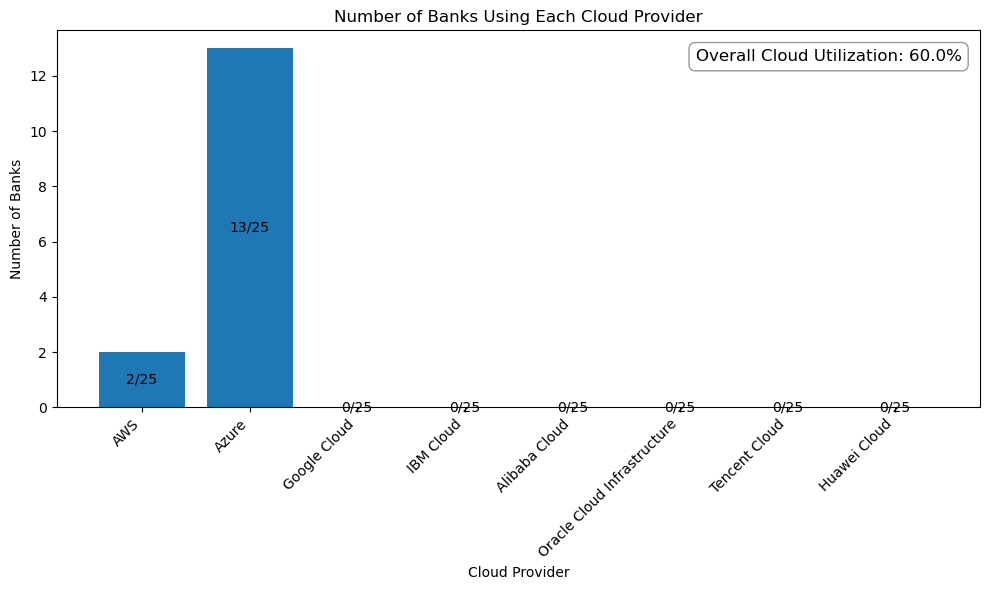

Plot generated successfully.


In [5]:
import csv
import ast
import matplotlib.pyplot as plt

# Specify the input CSV file path
csv_file = "/kaggle/input/bankdetails501/bank_details-5.0.1.csv"

# List of major cloud providers
major_cloud_providers = {
    "AWS": ["Amazon.com, Inc.", "Amazon Web Services"],
    "Azure": ["Microsoft Corporation", "Microsoft Azure"],
    "Google Cloud": ["Google LLC", "Google Cloud Platform", "Google Cloud"],
    "IBM Cloud": ["IBM Corporation", "IBM Cloud"],
    "Alibaba Cloud": ["Alibaba Group Holding Limited", "Alibaba Cloud"],
    "Oracle Cloud Infrastructure": ["Oracle Corporation", "Oracle Cloud"],
    "Tencent Cloud": ["Tencent Holdings Limited", "Tencent Cloud"],
    "Huawei Cloud": ["Huawei Technologies Co., Ltd.", "Huawei Cloud"],
}

# Read the bank details from the CSV file
bank_details = []
with open(csv_file, "r", encoding="utf-8") as file:
    reader = csv.DictReader(file)
    for row in reader:
        row["org_names"] = ast.literal_eval(row["org_names"])
        bank_details.append(row)

print("Loaded data from CSV file.")

# Add a new column to the dataset to store the cloud provider information
for bank in bank_details:
    cloud_provider = None
    for org_name in bank["org_names"]:
        org_name = org_name.strip("'")
        for provider, aliases in major_cloud_providers.items():
            if org_name in aliases:
                cloud_provider = provider
                break
        if cloud_provider:
            break
    bank["cloud_provider"] = cloud_provider

print("Mapped cloud providers for each bank.")

# Count the number of banks using each cloud provider
cloud_counts = {provider: 0 for provider in major_cloud_providers}
for bank in bank_details:
    provider = bank["cloud_provider"]
    if provider:
        cloud_counts[provider] += 1

print("Counted the number of banks using each cloud provider.")

# Calculate total number of banks using any cloud provider and total number of banks
total_banks_using_cloud = sum(cloud_counts.values())
total_banks = len(bank_details)

# Prepare data for plotting
providers = list(cloud_counts.keys())
counts = list(cloud_counts.values())

# Plot the bar chart with count and percentage annotations
plt.figure(figsize=(10, 6))
bars = plt.bar(providers, counts)
plt.xlabel("Cloud Provider")
plt.ylabel("Number of Banks")
plt.title("Number of Banks Using Each Cloud Provider")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add count and percentage annotations inside each bar
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f"{count}/{total_banks}",
        ha="center",
        va="center",
    )

# Add overall cloud utilization percentage outside the plot
overall_percentage = (total_banks_using_cloud / total_banks) * 100
plt.text(
    0.98,
    0.95,
    f"Overall Cloud Utilization: {overall_percentage:.1f}%",
    horizontalalignment="right",
    verticalalignment="top",
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray", boxstyle="round,pad=0.4"),
)

plt.show()

print("Plot generated successfully.")

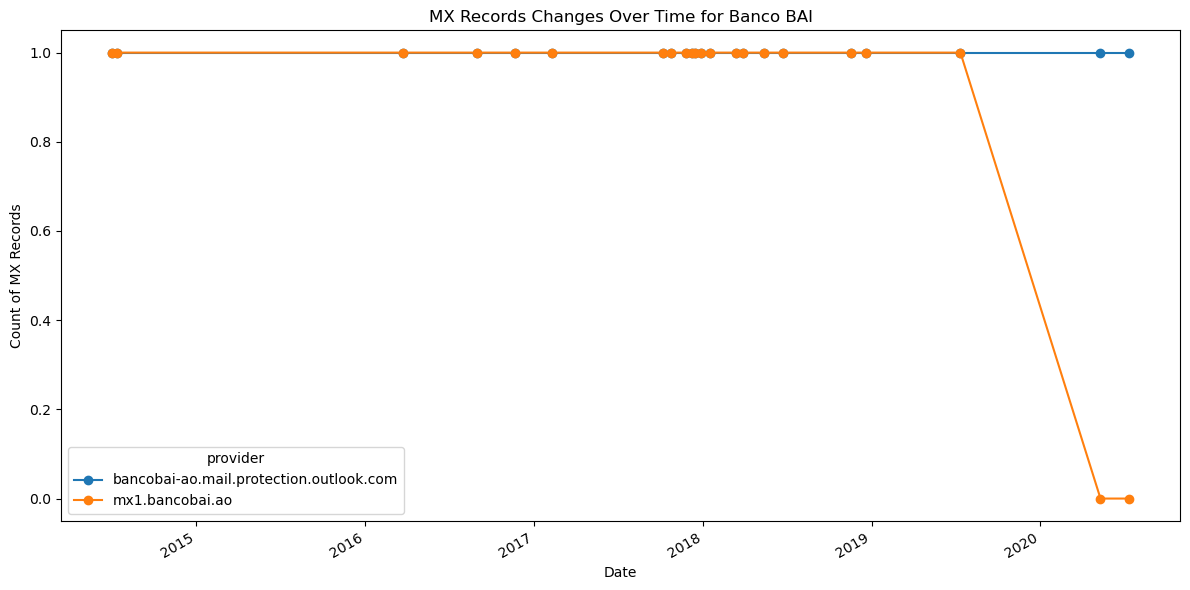

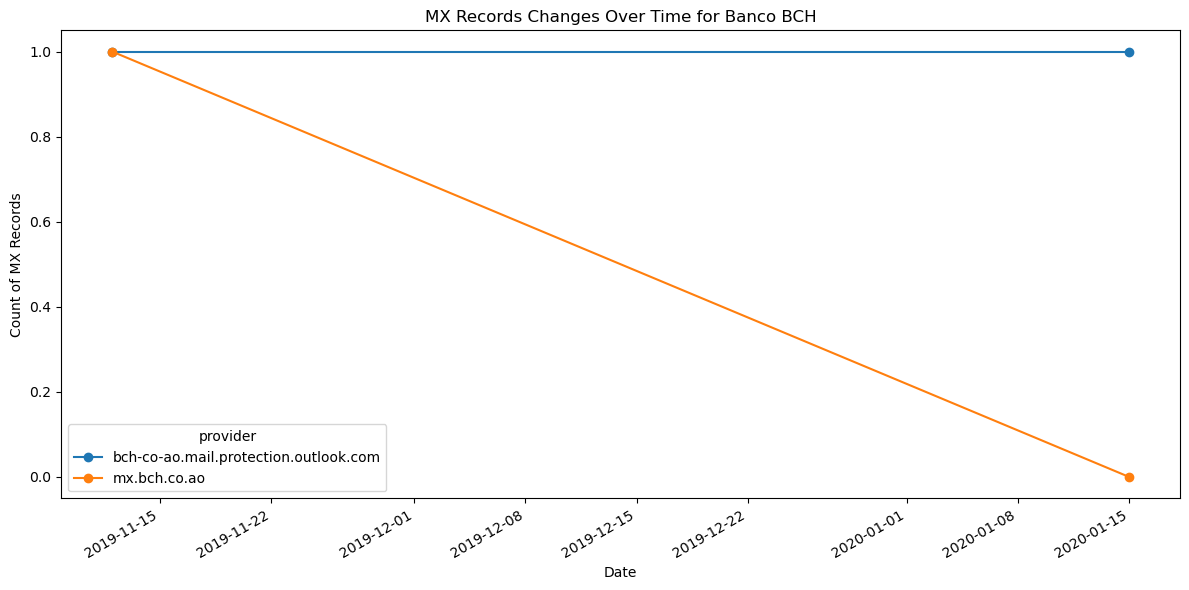

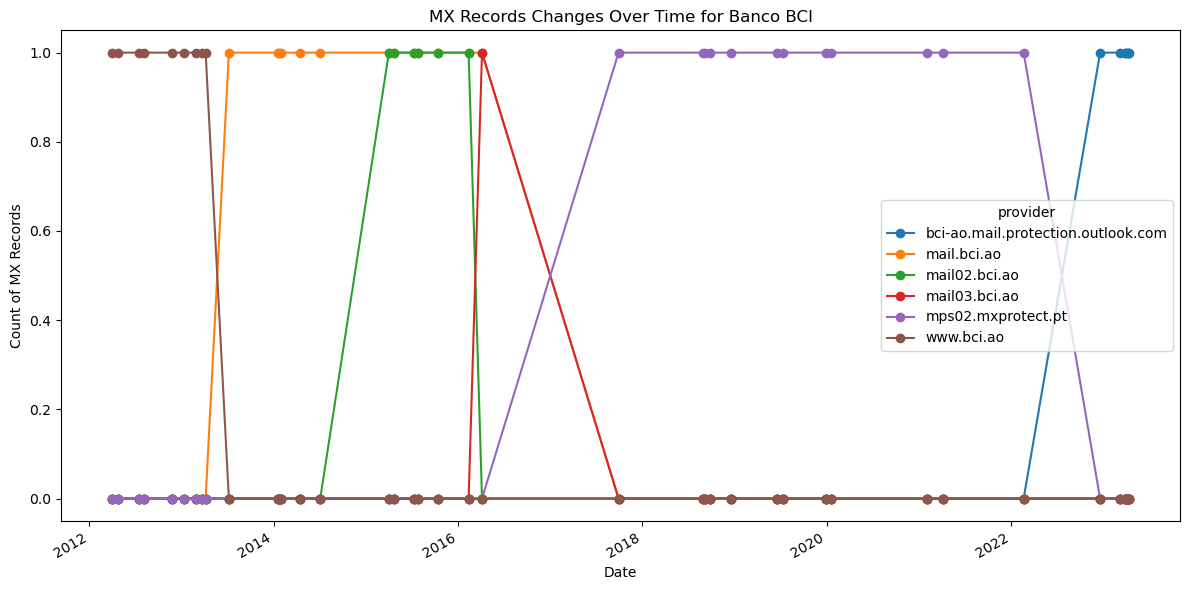

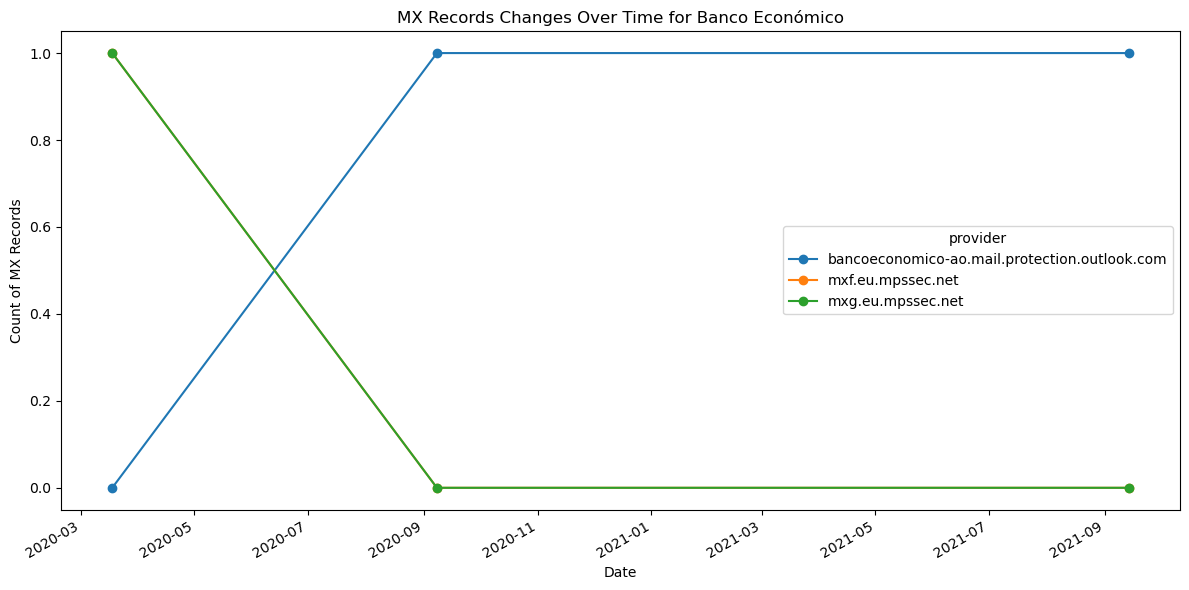

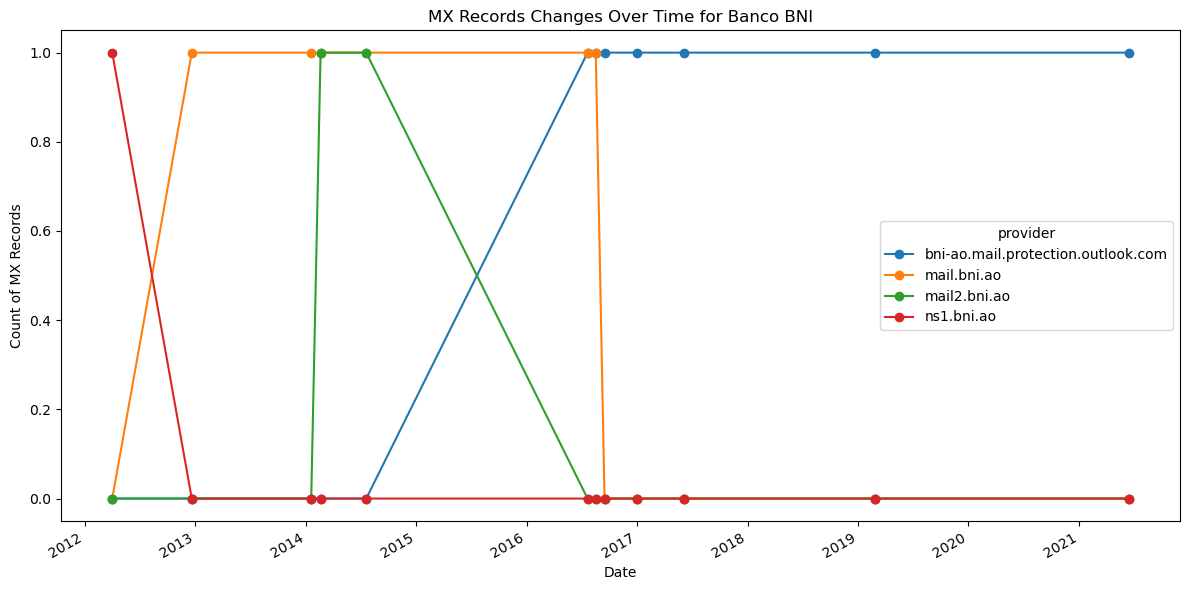

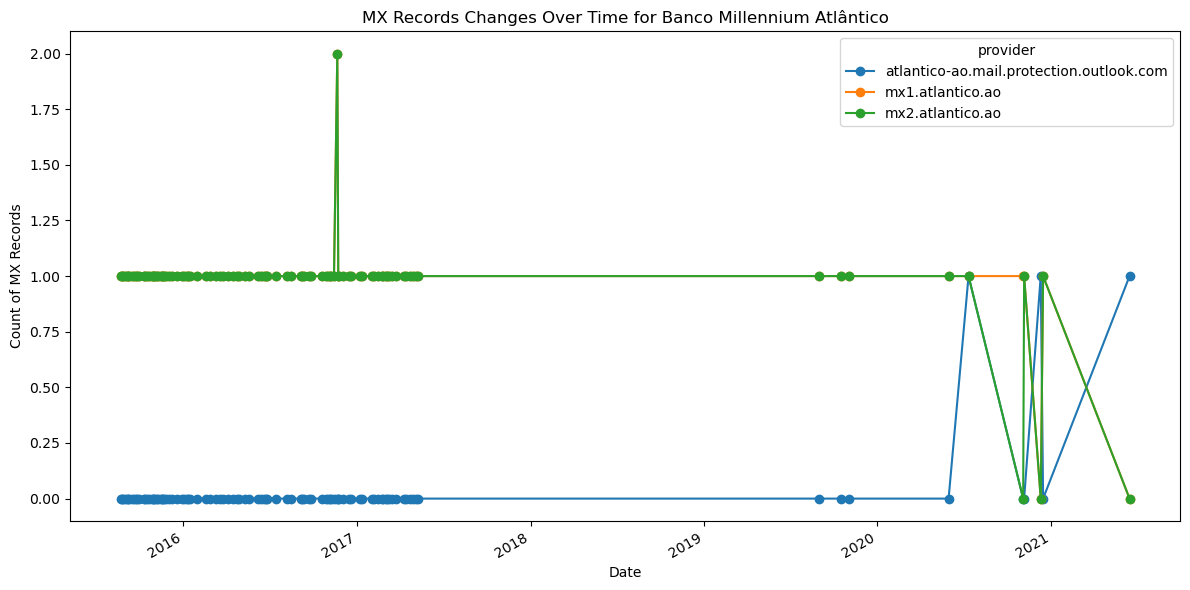

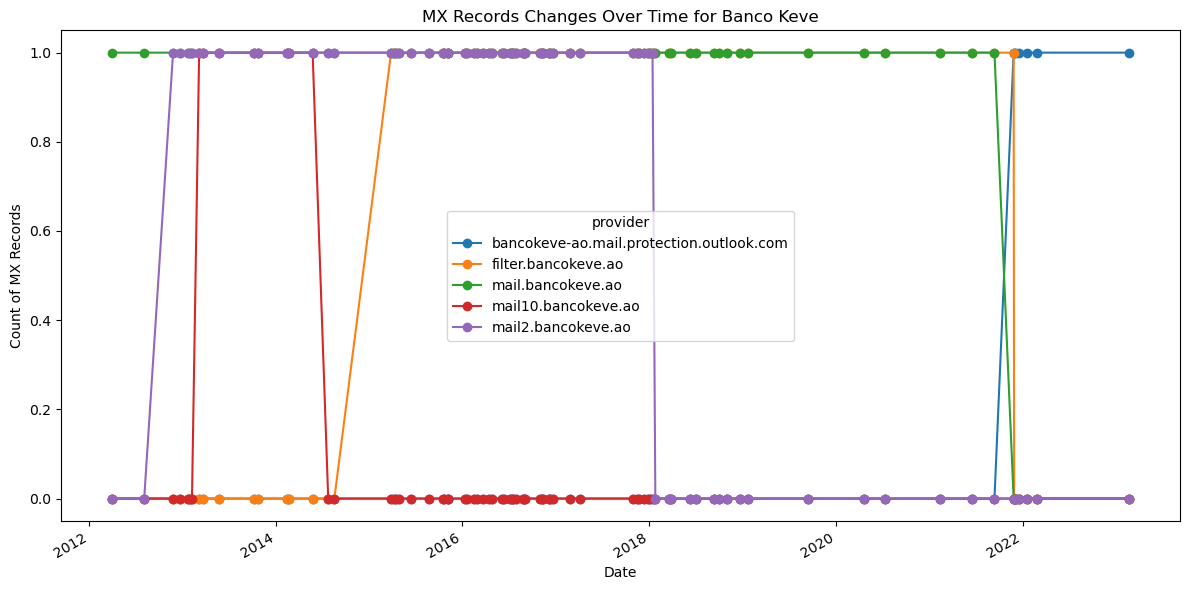

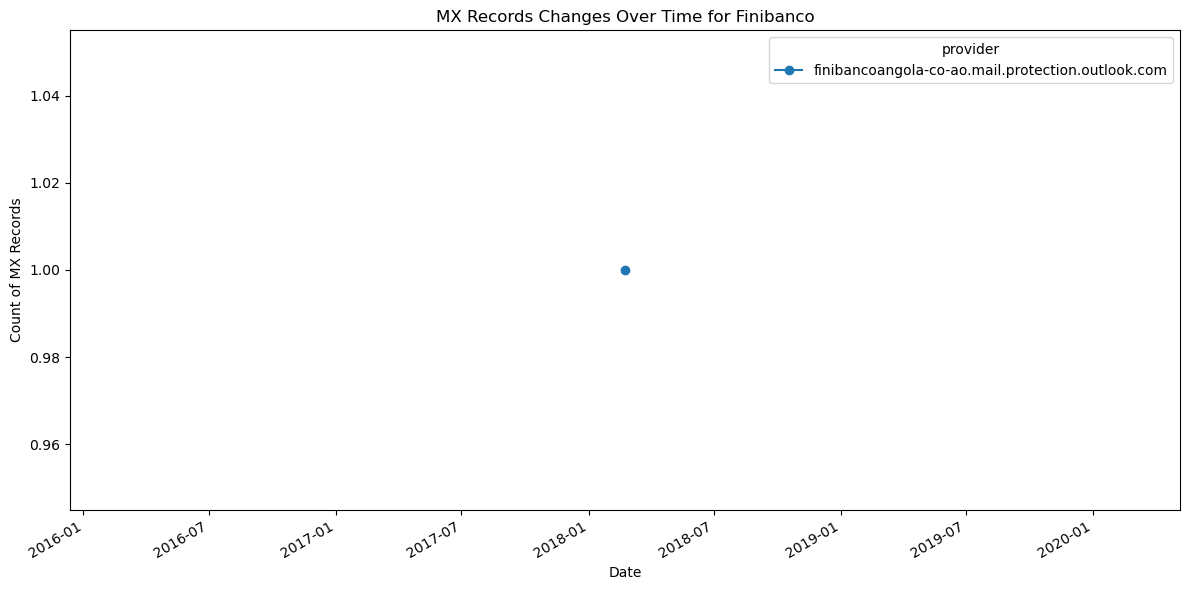

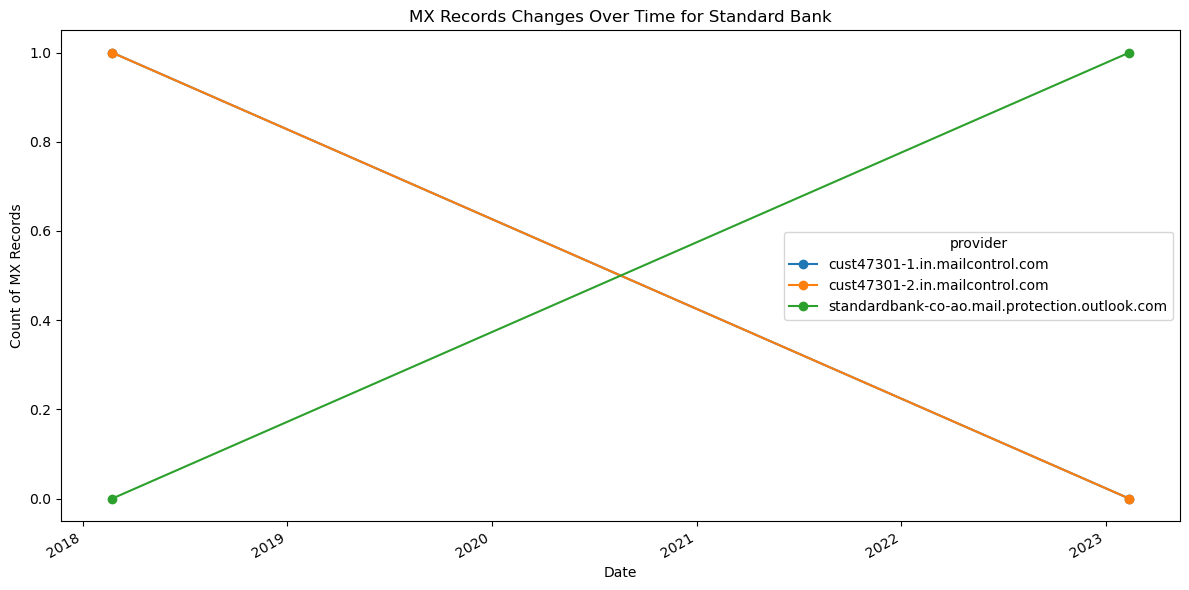

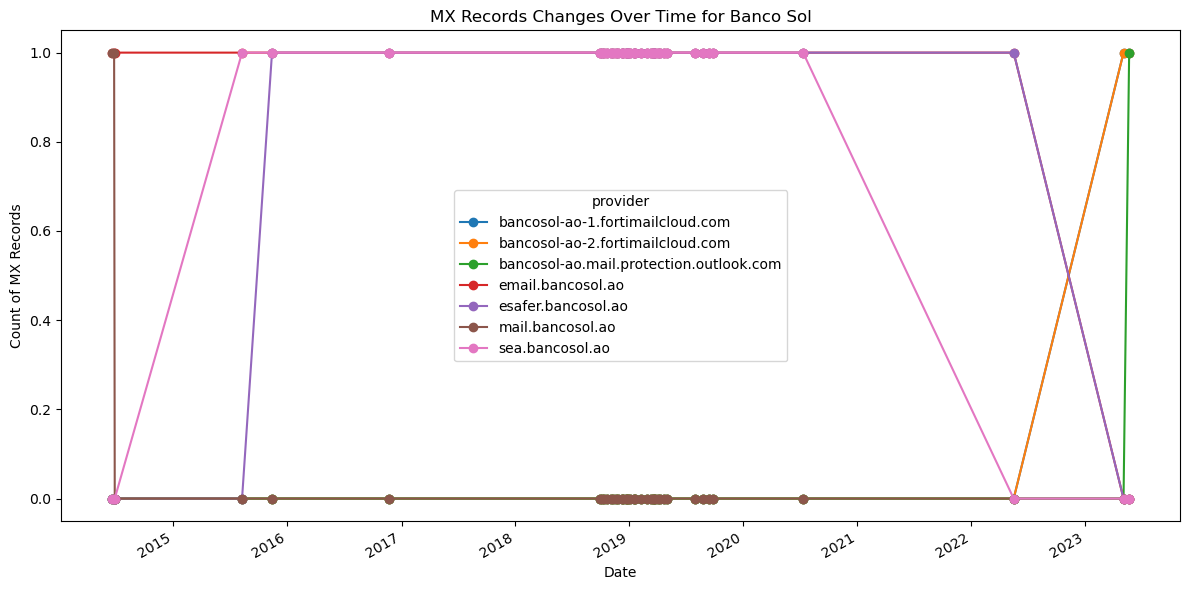

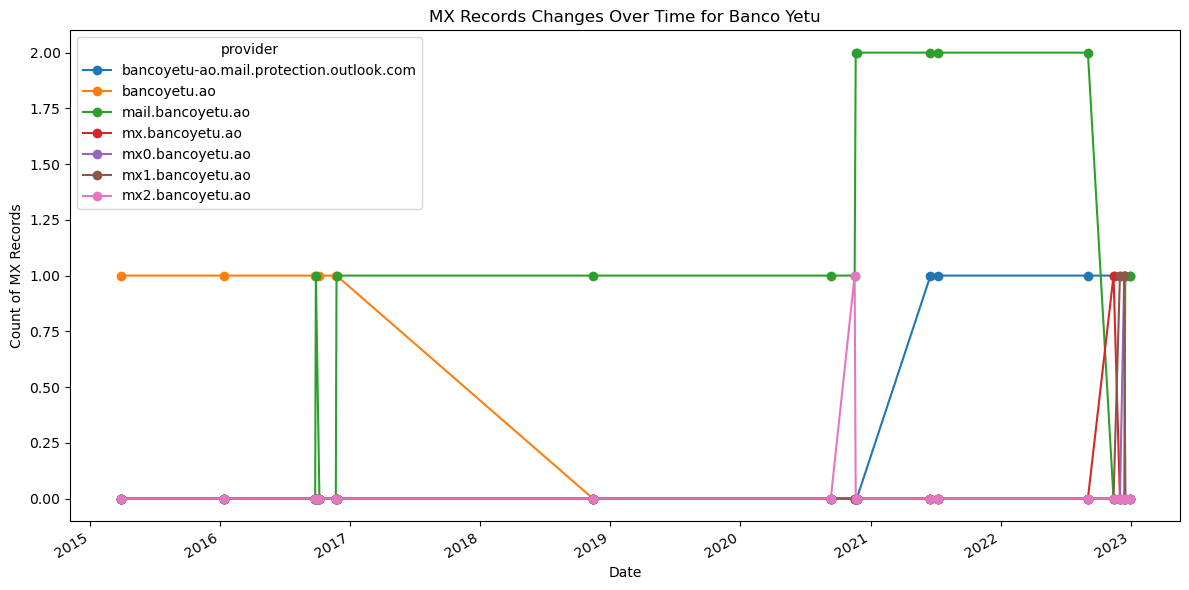

In [6]:
import json
import pandas as pd
import matplotlib.pyplot as plt

def plot_mx_records_changes(data, company_name):
    # Extract the records from the JSON data
    records = data.get('records', [])

    # Prepare a list of dictionaries to store the data
    mx_records_list = []

    for record in records:
        for value in record.get('values', []):
            entry = {
                'date': record.get('first_seen', 'N/A'),
                'provider': value.get('host', 'N/A')
            }
            mx_records_list.append(entry)

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(mx_records_list)

    # Convert the 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Group the data by date and provider
    grouped_data = df.groupby(['date', 'provider']).size().reset_index(name='count')

    # Pivot the data to get providers as columns
    pivot_data = grouped_data.pivot(index='date', columns='provider', values='count').fillna(0)

    # Plot the line chart for the specific company
    plt.figure(figsize=(12, 6))
    pivot_data.plot(kind='line', marker='o', ax=plt.gca())
    plt.xlabel('Date')
    plt.ylabel('Count of MX Records')
    plt.title(f'MX Records Changes Over Time for {company_name}')
    plt.tight_layout()
    plt.show()

# Example usage for different companies
with open('/kaggle/input/historicalmxrecordsbancobai/historical_mx_records_bancobai.json', 'r') as json_file:
    company1_data = json.load(json_file)
    plot_mx_records_changes(company1_data, 'Banco BAI')

with open('/kaggle/input/historicalmxrecordsbchcoao/historical_mx_records_bch.co.ao.json', 'r') as json_file:
    company2_data = json.load(json_file)
    plot_mx_records_changes(company2_data, 'Banco BCH')

with open('/kaggle/input/historicalmxrecordsbciao/historical_mx_records_bci.ao.json', 'r') as json_file:
    company3_data = json.load(json_file)
    plot_mx_records_changes(company3_data, 'Banco BCI')
    
with open('/kaggle/input/historicalmxrecordsbancoeconomicoao/historical_mx_records_bancoeconomico.ao.json', 'r') as json_file:
    company4_data = json.load(json_file)
    plot_mx_records_changes(company4_data, 'Banco Económico')
    
with open('/kaggle/input/historicalmxrecordsbniao/historical_mx_records_bni.ao.json', 'r') as json_file:
    company6_data = json.load(json_file)
    plot_mx_records_changes(company6_data, 'Banco BNI')
    
with open('/kaggle/input/historicalmxrecordsatlanticoao/historical_mx_records_atlantico.ao.json', 'r') as json_file:
    company7_data = json.load(json_file)
    plot_mx_records_changes(company7_data, 'Banco Millennium Atlântico')
    
with open('/kaggle/input/historicalmxrecordsbancokeveao/historical_mx_records_bancokeve.ao.json', 'r') as json_file:
    company8_data = json.load(json_file)
    plot_mx_records_changes(company8_data, 'Banco Keve')
    
with open('/kaggle/input/historicalmxrecordsfinibancocoao/historical_mx_records_finibanco.co.ao.json', 'r') as json_file:
    company9_data = json.load(json_file)
    plot_mx_records_changes(company9_data, 'Finibanco')
    
with open('/kaggle/input/historicalmxrecordsstandardbankcoao/historical_mx_records_standardbank.co.ao.json', 'r') as json_file:
    company10_data = json.load(json_file)
    plot_mx_records_changes(company10_data, 'Standard Bank')
    
with open('/kaggle/input/historicalmxrecordsbancosolao/historical_mx_records_bancosol.ao.json', 'r') as json_file:
    company11_data = json.load(json_file)
    plot_mx_records_changes(company11_data, 'Banco Sol')
    
with open('/kaggle/input/historicalmxrecordsbancoyetuao/historical_mx_records_bancoyetu.ao.json', 'r') as json_file:
    company12_data = json.load(json_file)
    plot_mx_records_changes(company12_data, 'Banco Yetu')